In [1]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')

In [2]:
from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 1,
        pretrained = False, progress= True)).to(device)

Initializing conv2d weights with Kaiming He normal


In [5]:
model.load_state_dict(torch.load('../model_results_torch/c-resunet_v3.h5'))

<All keys matched successfully>

In [17]:
model.train()

DataParallel(
  (module): ResUnet(
    (encoder): ModuleDict(
      (colorspace): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
      (conv_block): ConvBlock(
        (conv_block): ModuleDict(
          (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (activation_1): ELU(alpha=1.0)
          (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (activation_4): ELU(alpha=1.0)
          (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (residual_block1): ResidualBlock(
        (conv_path): ConvBlock(
          (conv_block): ModuleDict(
            (batchnorm2d_0): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [8]:
root = "/davinci-1/home/morellir/artificial_intelligence/repos" +\
"/cell_counting_torch/DATASET/test/"
transform = T.Compose([T.Lambda(lambda x: x*1./255)])
cells_images = CellsLoader(root + "all_images/images/",
                           root + "all_masks/masks/", 
                           val_split=0.3, transform = transform)

In [9]:
batch_size = 4
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [10]:
x, y = next(iter(test_loader))

In [11]:
import matplotlib.pyplot as plt

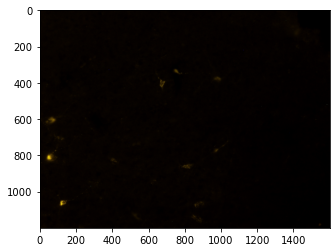

In [12]:
plt.imshow(x[0])

In [18]:
heatmap = model(x.permute(0,3,1,2).float().to(device))

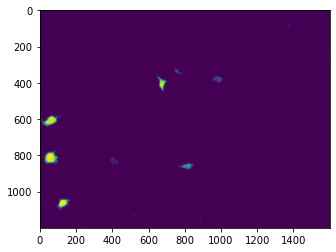

In [19]:
plt.imshow(heatmap[0].cpu().detach().squeeze())

In [68]:
#y = y.permute(0, 3, 1, 2)
#x = x.permute(0, 3, 1, 2)

In [72]:
y.size()

torch.Size([4, 3, 1200, 1600])

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

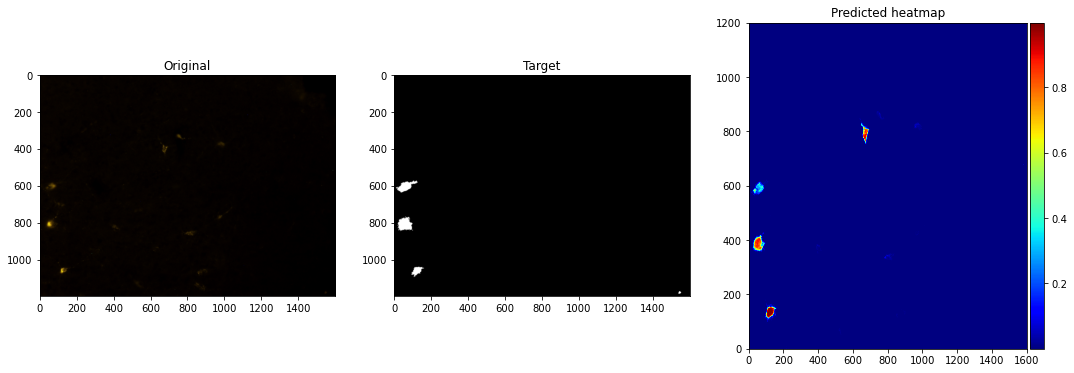

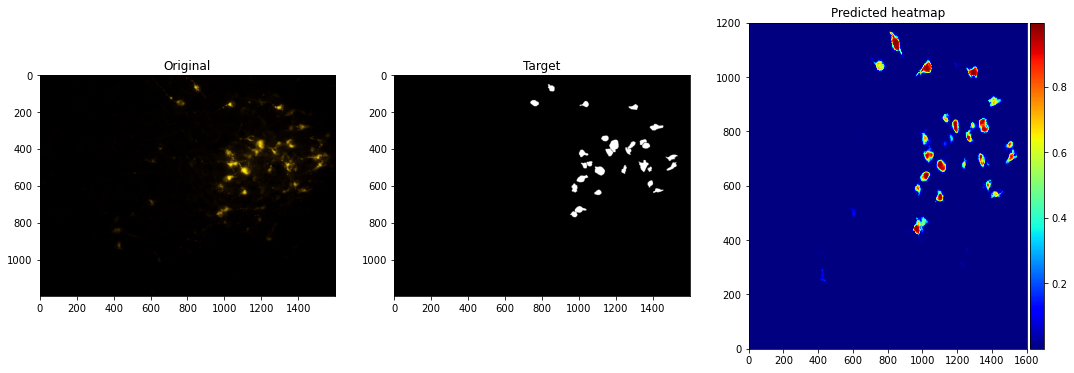

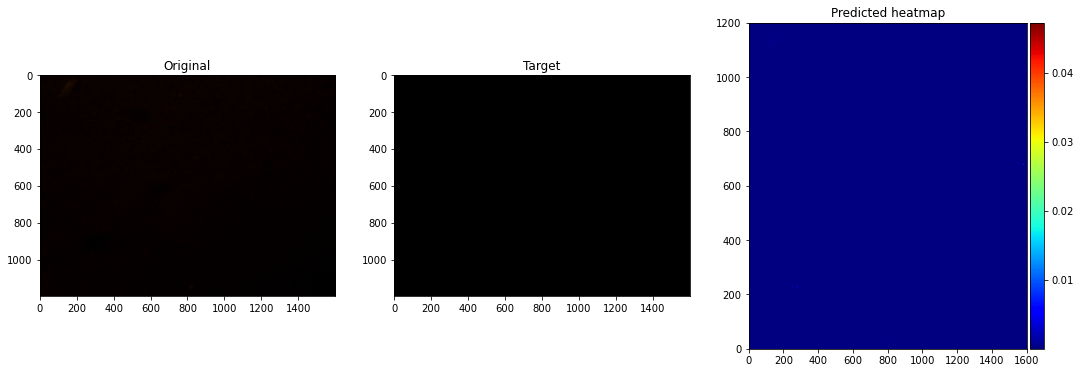

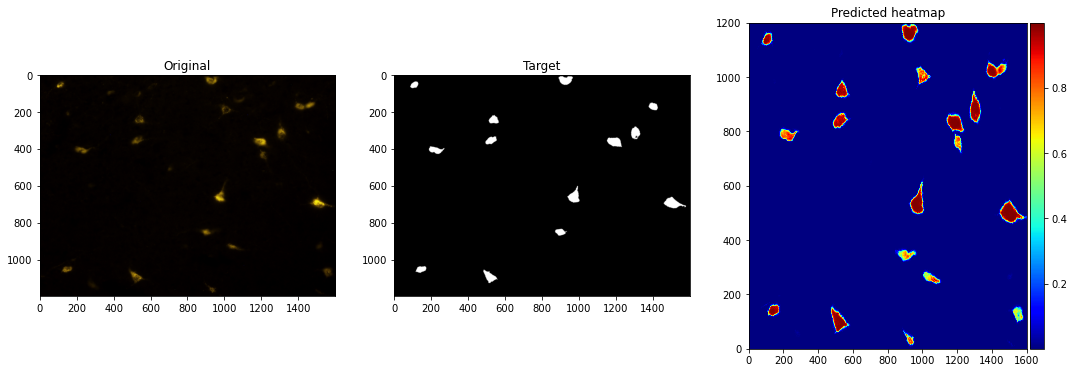

In [16]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i]
    target = y[i]
    heat_map = heatmap[i]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
       
    im = axes[0].imshow(original)
    axes[0].set_title('Original')
    
    im = axes[1].imshow(np.squeeze(target), cmap='gray')
    axes[1].set_title('Target')
    
    im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[2].set_title('Predicted heatmap') 


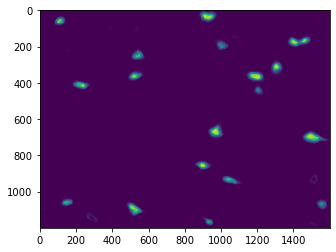

In [41]:
for heat in heatmap:
    plt.imshow(heat.cpu().detach().squeeze())